In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [116]:
np.random.seed(7)

df = pd.read_csv('data/sign_mnist_train.csv')

imgs =df.iloc[:,1:]
y = df.iloc[:,0:1]
y = y.to_numpy()
y_train = np.zeros((27455, 25))
for i, y in enumerate(y):
    y_train[i][y-1] = 1
mean = np.mean(imgs) 
stdev = np.std(imgs)
x_train = (imgs - mean) / stdev
x_train = x_train.to_numpy()

df_test = pd.read_csv('data/sign_mnist_test.csv')
imgs_t = df_test.iloc[:, 1:]
y = df_test.iloc[:, 0:1]
y = y.to_numpy()
y_test = np.zeros((7172, 25))
for i,y in enumerate(y):
    y_test[i][y-1] = 1

mean = np.mean(imgs_t)
stdev = np.std(imgs_t)
x_test = (imgs_t - mean) / stdev
x_test = x_test.to_numpy()
print(len(x_test))


7172


In [ ]:
def sigmoid (x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid (y):
    return y * (1.0 - y)

def tanh (x):
    return np.tanh (x)

def dtanh (y):
    return 1 - y**2

def relu (x):
    return np.maximum (x, 0)

def drelu (y):
    return (y > 0)*1

In [125]:
class MultiLayerPerceptron:
  def __init__ (self, features, hidden_layers, hidden_neurons, output_neurons, f_activation, learning_rate):
    self.features = features
    self.h_layers = hidden_layers
    self.h_neurons = hidden_neurons
    self.o_neurons = output_neurons

    self.fa = sigmoid
    self.dfa = dsigmoid
    if (f_activation == 0):
      self.fa = sigmoid
      self.dfa = dsigmoid
    elif (f_activation == 1):
      self.fa = tanh
      self.dfa = dtanh
    elif (f_activation == 2):
      self.fa = relu
      self.dfa = drelu

    self.l_rate = learning_rate
    self.generate_layers()
  
  # esta funcion construye una matrix de pesos aleatoriamente agregando una columna adicional
  # de bias
  # neuron_count: numero de perceptrones
  # input_count: numero de features de un elemento
  def layer_w (self, neuron_count, input_count):
    weights = np.zeros((neuron_count, input_count+1))
    for i in range(neuron_count):
      for j in range(1, (input_count+1)):
        weights[i][j] = np.random.uniform(-0.1, 0.1)
    return weights

  def generate_layers (self):
    # Generation for hidden layers
    self.hidden_layer_w = self.layer_w (self.h_neurons, self.features)
    self.hidden_layer_y = np.zeros (self.h_neurons)
    self.hidden_layer_error = np.zeros (self.h_neurons)

    # Generation for output layer
    self.output_layer_w = self.layer_w (self.o_neurons, self.h_neurons)
    self.output_layer_y = np.zeros (self.o_neurons)
    self.output_layer_error = np.zeros (self.o_neurons)

  #parametro x es una muestra del dataset (1, n) donde n es el num de features
  def forward_pass (self, x):
    for i, w in enumerate (self.hidden_layer_w):
      z = np.dot (w, x)
      self.hidden_layer_y [i] = self.fa(z)
    hidden_output_array = np.concatenate((np.array([1.0]), self.hidden_layer_y))

    for i, w in enumerate (self.output_layer_w):
      z = np.dot (w, hidden_output_array)
      self.output_layer_y [i] = 1.0 / (1.0 + np.exp(-z))

  #y_valid: one hot encoding(1,25) representando una letra
  def backward_pass (self, y_truth):
    #calculamos el error con respecto a la capa de salida
    for i, y in enumerate (self.output_layer_y):
      error_prime = -(y_truth[i] - y)
      derivative = y * (1.0 - y)
      self.output_layer_error[i] = error_prime * derivative

    #iteramos la capa hidden, i -> neural 
    #guardamos pesos relacionados a neural i de la capa output
    for i,y in enumerate(self.hidden_layer_y):
      error_weights = []
      for w in self.output_layer_w:
          error_weights.append(w[i+1])
      error_weight_array = np.array(error_weights)
      
      derivative = self.dfa (y)
      #calculamos el error propagado de neural i 
      weighted_error = np.dot(error_weight_array, self.output_layer_error)
      #calculamos el error con respecto a la funcion de activacion
      self.hidden_layer_error[i] = weighted_error * derivative

  # x es una muestra de (1,785)
  def adjust_weights(self, x):
    for i, error in enumerate (self.hidden_layer_error):
      self.hidden_layer_w [i] -= (x * self.l_rate * error)

    hidden_output_array = np.concatenate ((np.array([1.0]), self.hidden_layer_y))
    
    for i, error in enumerate (self.output_layer_error):
      self.output_layer_w [i] -= (hidden_output_array * self.l_rate * error)

  def training (self, x_data, y_data, x_test, y_test):
    index_list = list(range(len(x_data)))
    chart_x = []
    chart_y_train = []
    chart_y_test = []
    for i in range(10): # num de epocas => 10
      np.random.shuffle(index_list)
      correct_training_results = 0
      for j in index_list:
        x = np.concatenate((np.array([1.0]), x_data[j]))
        self.forward_pass (x)
        if self.output_layer_y.argmax() == y_data[j].argmax():
          correct_training_results +=1
        self.backward_pass (y_data[j])
        self.adjust_weights (x)
      accuracy = correct_training_results/len(x_data)
      
      chart_x.append(i + 1)
      chart_y_train.append(1.0 - accuracy)

      correct_test_results = 0
      for j in range(len(x_test)):
        x = np.concatenate((np.array([1.0]), x_test[j]))
        self.forward_pass(x)
        if self.output_layer_y.argmax() == y_test[j].argmax():
          correct_test_results += 1

      accuracy2 = correct_test_results/len(x_test)
      chart_y_test.append(1.0 - accuracy2)
      print('epoch no:', i+1, ', train accuracy: ', '%6.4f' % accuracy, ', test accuracy: ', '%6.4f' % accuracy2)
    return chart_x, chart_y_train, chart_y_test


In [126]:
mlp = MultiLayerPerceptron(784, 1, 60, 25, 1, 0.01)
epochs, train, test = mlp.training(x_train, y_train, x_test, y_test)

epoch no: 0 , train accuracy:  0.6966 , test accuracy:  0.6764
epoch no: 1 , train accuracy:  0.9372 , test accuracy:  0.7210
epoch no: 2 , train accuracy:  0.9755 , test accuracy:  0.7190
epoch no: 3 , train accuracy:  0.9803 , test accuracy:  0.7228
epoch no: 4 , train accuracy:  0.9824 , test accuracy:  0.7170
epoch no: 5 , train accuracy:  0.9838 , test accuracy:  0.7193
epoch no: 6 , train accuracy:  0.9838 , test accuracy:  0.7149
epoch no: 7 , train accuracy:  0.9842 , test accuracy:  0.7192
epoch no: 8 , train accuracy:  0.9854 , test accuracy:  0.7117
epoch no: 9 , train accuracy:  0.9854 , test accuracy:  0.7167


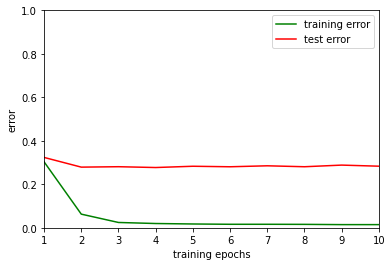

In [129]:
def plot_learning(epochs, train, test):
    plt.plot(epochs, train, 'g', label='training error')
    plt.plot(epochs, test, 'r-', label='test error')
    plt.axis([1, len(epochs), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()
plot_learning(epochs, train, test)

epoch no: 0 , train accuracy:  0.7860 , test accuracy:  0.7026
epoch no: 1 , train accuracy:  0.9562 , test accuracy:  0.7227
epoch no: 2 , train accuracy:  0.9769 , test accuracy:  0.7430
epoch no: 3 , train accuracy:  0.9821 , test accuracy:  0.7489
epoch no: 4 , train accuracy:  0.9850 , test accuracy:  0.7467
epoch no: 5 , train accuracy:  0.9859 , test accuracy:  0.7578
epoch no: 6 , train accuracy:  0.9865 , test accuracy:  0.7563
epoch no: 7 , train accuracy:  0.9865 , test accuracy:  0.7575
epoch no: 8 , train accuracy:  0.9865 , test accuracy:  0.7603
epoch no: 9 , train accuracy:  0.9865 , test accuracy:  0.7589


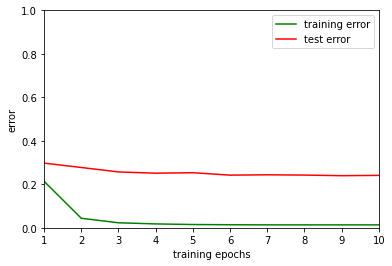

In [130]:
# segundo intento modificando learning rate mas grande, seguimos en la barrera
# del 75 de accuracy con el test set , debemos cambiar el modelo
mlp = MultiLayerPerceptron(784, 1, 60, 25, 1, 0.1)
epochs, train, test = mlp.training(x_train, y_train, x_test, y_test)
plot_learning(epochs, train, test)